In [ ]:
!pip install optuna
!pip install shap
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 4.3 MB/s 
     |████████████████████████████████| 209 kB 52.1 MB/s 
     |████████████████████████████████| 81 kB 10.0 MB/s 
     |████████████████████████████████| 78 kB 8.0 MB/s 
     |████████████████████████████████| 112 kB 57.4 MB/s 
     |████████████████████████████████| 147 kB 37.9 MB/s 
     |████████████████████████████████| 49 kB 6.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=d944b5fcd4fbb49575f6e87fec4f3cdeffae8cf75e11c4aad6e9100ac52532d0
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 4.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,RidgeCV,LassoCV,Ridge,Lasso
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import statsmodels.formula.api as sm
from xgboost import XGBRegressor
import datetime
from datetime import *
import lightgbm as lgbm
import optuna
import catboost as cb
import shap

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Capstone - HR /Output1 (1).csv')

#### Few preprocessing steps

In [ ]:
df.drop(columns=["Candidate_in_demand"],axis=1,inplace=True)
df["Inhand_Offer"]=df["Inhand_Offer"].map({'N':0,'Y':1})
df.replace(to_replace="Sr. Business Analyst",value="Senior Business Analyst",inplace=True)
df.replace(to_replace='Sr.Manager',value="Senior Manager",inplace=True)
df.replace(to_replace='Analytics/BI',value="Analytics or BI",inplace=True)
df.replace(to_replace='IT-Software',value="IT and Software",inplace=True)

#### Target Encoding

In [ ]:
cat_col = df.select_dtypes(exclude=[np.number]).columns.tolist()

In [ ]:
cat_col

['Department',
 'Role',
 'Industry',
 'Organization',
 'Designation',
 'Education',
 'Graduation_Specialization',
 'University_Grad',
 'Last_Appraisal_Rating']

In [ ]:
for i in cat_col:
  global_mean = df["Expected_CTC"].mean()
  data=df.groupby(i).agg({i:"count","Expected_CTC":"mean"})
  data.rename(columns={i:"Count","Expected_CTC":"Mean"},inplace=True)
  counts = data["Count"]
  means = data["Mean"]
  m = 100
  smooth = (counts*means + m*global_mean)/(counts+m)
  df.loc[:,i+"_enc"]=df[i].map(smooth)

In [ ]:
from sklearn.preprocessing import Target

In [ ]:
df.drop(columns=cat_col,inplace=True)

#### Multiple linear regression

In [ ]:
def ohe(df):
  cat_col = df.select_dtypes(exclude=[np.number]).columns.tolist()
  df = pd.get_dummies(data=df,columns=cat_col)
  new = []
  for i in df.columns:
    new.append("_".join(i.split()))
  for (i,j) in zip(df.columns,new):
    df.rename(columns={i:j},inplace=True)
  return df,list(df.columns)

In [ ]:
data = df.copy()

In [ ]:
data,cols1 = ohe(data)

##### Determining VIF

In [ ]:
import statsmodels.formula.api as sm
def vif_cal(input_data):
    x_vars=input_data
    xvar_names=input_data.columns
    VIF = []
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]] 
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.ols(formula="y~x", data=x_vars).fit().rsquared  
        vif=round(1/(1-rsq),2)
        VIF.append(vif)
        #print (xvar_names[i], " VIF = " , vif)
    df = pd.DataFrame(index=xvar_names,data=VIF,columns=["VIF"])
    return df.sort_values(by='VIF',ascending=False)

In [ ]:
df.shape

(25000, 17)

In [ ]:
input_data = d.drop(columns=["Expected_CTC"],axis=1)

In [ ]:
vif_df=vif_cal(input_data)

PatsyError: ignored

In [ ]:
vif_df.loc[vif_df["VIF"]!=np.inf,:]

NameError: ignored

#### Dython Correlation

In [ ]:
from dython import nominal
from dython.nominal import associations

In [ ]:
cat_df = df[cat_col]

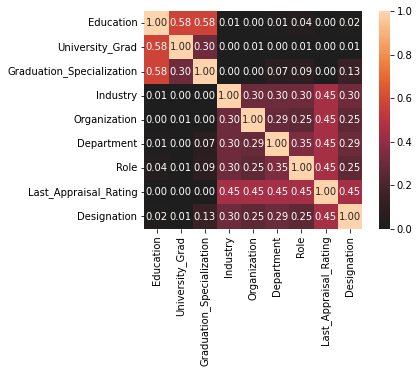

In [ ]:
assoc=associations(cat_df,plot=False,clustering=True)
correlations=assoc['corr']

#### User defined functions

In [ ]:
def Linear_Regression_Sklearn(data,model_name):
  X = data.drop("Expected_CTC",axis=1)
  Y = data["Expected_CTC"]
  X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=1)
  kf = KFold(n_splits=5)
  for (train_idx,test_idx) in kf.split(X_train,Y_train):
    X_train_cv,X_test_cv=X_train.iloc[train_idx],X_train.iloc[test_idx]
    Y_train_cv,Y_test_cv=Y_train.iloc[train_idx],Y_train.iloc[test_idx]
    lr = LinearRegression()
    lr.fit(X_train_cv,Y_train_cv)
  train_pred = lr.predict(X_train)
  test_pred = lr.predict(X_test)
  train_rmse = mean_squared_error(Y_train,train_pred,squared=False)
  test_rmse = mean_squared_error(Y_test,test_pred,squared=False)
  train_mae = mean_absolute_error(Y_train,train_pred)
  test_mae = mean_absolute_error(Y_test,test_pred)
  train_mape = mean_absolute_percentage_error(Y_train,train_pred)
  test_mape = mean_absolute_percentage_error(Y_test,test_pred)
  r2_sq_train = r2_score(Y_train,train_pred)
  r2_sq_test = r2_score(Y_test,test_pred)
  data = pd.DataFrame(columns=[model_name],data=[train_rmse,test_rmse,r2_sq_train,r2_sq_test],index=["Train RMSE","Test RMSE","R-sq_Train","R-sq_Test"])
  return data

In [ ]:
def Decision_Tree(data,model_name):
  X = data.drop("Expected_CTC",axis=1)
  Y = data["Expected_CTC"]
  X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=1)
  kf=KFold(n_splits=5)
  for (train_idx,test_idx) in kf.split(X_train,Y_train):
    X_train_cv,X_test_cv=X_train.iloc[train_idx],X_train.iloc[test_idx]
    Y_train_cv,Y_test_cv=Y_train.iloc[train_idx],Y_train.iloc[test_idx]
    dt = DecisionTreeRegressor()
    dt.fit(X_train_cv,Y_train_cv)
  train_pred = dt.predict(X_train)
  test_pred = dt.predict(X_test)
  train_rmse = mean_squared_error(Y_train,train_pred,squared=False)
  test_rmse = mean_squared_error(Y_test,test_pred,squared=False)
  train_mae = mean_absolute_error(Y_train,train_pred)
  test_mae = mean_absolute_error(Y_test,test_pred)
  train_mape = mean_absolute_percentage_error(Y_train,train_pred)
  test_mape = mean_absolute_percentage_error(Y_test,test_pred)
  r2_sq_train = r2_score(Y_train,train_pred)
  r2_sq_test = r2_score(Y_test,test_pred)
  data = pd.DataFrame(columns=[model_name],data=[train_rmse,test_rmse,r2_sq_train,r2_sq_test],index=["Train RMSE","Test RMSE","R-sq_Train","R-sq_Test"])
  return data

In [ ]:
def Random_Forest(data,model_name,set_params,params):
  X = data.drop("Expected_CTC",axis=1)
  Y = data["Expected_CTC"]
  if set_params:
    rf=RandomForestRegressor(**params)
  else:
    rf=RandomForestRegressor()
  X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=1)
  kf=KFold(n_splits=5)
  for (train_idx,test_idx) in kf.split(X,Y):
    X_train1,X_test1=X.iloc[train_idx],X.iloc[test_idx]
    Y_train1,Y_test1=Y.iloc[train_idx],Y.iloc[test_idx]
    rf.fit(X_train1,Y_train1)
  train_pred = rf.predict(X_train)
  test_pred = rf.predict(X_test)
  train_rmse = mean_squared_error(Y_train,train_pred,squared=False)
  test_rmse = mean_squared_error(Y_test,test_pred,squared=False)
  train_mae = mean_absolute_error(Y_train,train_pred)
  test_mae = mean_absolute_error(Y_test,test_pred)
  train_mape = mean_absolute_percentage_error(Y_train,train_pred)
  test_mape = mean_absolute_percentage_error(Y_test,test_pred)
  r2_sq_train = r2_score(Y_train,train_pred)
  r2_sq_test = r2_score(Y_test,test_pred)
  data = pd.DataFrame(columns=[model_name],data=[train_rmse,test_rmse,r2_sq_train,r2_sq_test],index=["Train RMSE","Test RMSE","R-sq_Train","R-sq_Test"])
  return data

In [ ]:
def XGBoost(data,model_name,set_params,params):
    X = data.drop("Expected_CTC",axis=1)
    Y = data["Expected_CTC"]
    if set_params:
      xgb=XGBRegressor(**params)
    else:
      xgb=XGBRegressor()
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=1)
    kf=KFold(n_splits=5)
    for (train_idx,test_idx) in kf.split(X_train,Y_train):
      X_train_cv,X_test_cv=X_train.iloc[train_idx],X_train.iloc[test_idx]
      Y_train_cv,Y_test_cv=Y_train.iloc[train_idx],Y_train.iloc[test_idx]
      xgb.fit(X_train_cv,Y_train_cv)
    train_pred = xgb.predict(X_train)
    test_pred = xgb.predict(X_test)
    train_rmse = mean_squared_error(Y_train,train_pred,squared=False)
    test_rmse = mean_squared_error(Y_test,test_pred,squared=False)
    train_mae = mean_absolute_error(Y_train,train_pred)
    test_mae = mean_absolute_error(Y_test,test_pred)
    train_mape = mean_absolute_percentage_error(Y_train,train_pred)
    test_mape = mean_absolute_percentage_error(Y_test,test_pred)
    r2_sq_train = r2_score(Y_train,train_pred)
    r2_sq_test = r2_score(Y_test,test_pred)
    data = pd.DataFrame(columns=[model_name],data=[train_rmse,test_rmse,r2_sq_train,r2_sq_test],index=["Train RMSE","Test RMSE","R-sq_Train","R-sq_Test"])
    return data

In [ ]:
def cols_to_be_dropped(df,cols):
  df.drop(columns=cols,axis=1,inplace=True)
  return df

#### Analysis

In [ ]:
# With all the features

In [ ]:
X = df.drop(["Expected_CTC"],axis=1)
Y = df["Expected_CTC"]

In [ ]:
Metrics = Linear_Regression_Sklearn(X,Y,'LR:all feat.')
Metrics

,LR:all feat.
Train RMSE,75087.176602
Test RMSE,74771.492188
R-sq_Train,0.995781
R-sq_Test,0.995921


In [ ]:
data1,cols = ohe(df)

In [ ]:
Metricsb=Linear_Regression_Sklearn(data1,'LR:all feat.CV')

In [ ]:
Metrics = pd.concat([Metrics,Metricsb],axis=1)

In [ ]:
Metrics

,LR:all feat.,LR:Uni_grad removed,DT:all feat.,DT:all feat.CV,LR:all feat.CV
Train RMSE,75087.176602,75112.626875,21517.908983,28375.614949,75133.049779
Test RMSE,74771.492188,74744.165164,48401.099242,47371.287205,74878.510588
R-sq_Train,0.995781,0.995778,0.999654,0.999397,0.995776
R-sq_Test,0.995921,0.995924,0.998291,0.998363,0.995909


In [ ]:
# Dropping University_Grad
data = df.copy()

In [ ]:
data.drop("University_Grad",axis=1,inplace=True)

In [ ]:
data,cols=ohe(data)

In [ ]:
#Metricsd = Linear_Regression_Sklearn(data,'LR:Uni_grad removed.CV')
#Metricse = Random_Forest(data,'RF:Uni_grad removed.CV')
Metricsf = Random_Forest(data,'RF:all feat.CV')
Metrics = pd.concat([Metrics,Metricsf],axis=1)

In [ ]:
#Metrics = pd.concat([Metrics,Metricsd],axis=1)
Metrics

,LR:all feat.,LR:Uni_grad removed,DT:all feat.,DT:all feat.CV,"DT:Org,Uni_grad removed CV",RF:Uni_grad removed.CV,RF:all feat.CV
Train RMSE,75087.176602,75112.626875,21517.908983,28375.614949,34671.368681,34468.025649,28545.979162
Test RMSE,74771.492188,74744.165164,48401.099242,47371.287205,40748.951729,38142.625990,40412.775023
R-sq_Train,0.995781,0.995778,0.999654,0.999397,0.999100,0.999111,0.999390
R-sq_Test,0.995921,0.995924,0.998291,0.998363,0.998789,0.998939,0.998808


In [ ]:
#Cross validation didn't bring much impact onto Linear Regression but it did lower down the overfitting in Decision Trees
Metrics.drop(columns=["LR:all feat.CV","LR:Uni_grad removed.CV"],axis=1,inplace=True)

In [ ]:
#Dropping Organization
data = df.copy()

In [ ]:
data = cols_to_be_dropped(data,["University_Grad","Organization"])

In [ ]:
data,cols = ohe(data)

In [ ]:
Metricsd=Linear_Regression_Sklearn(data,"LR:Org,Uni_grad removed CV")
Metrics=pd.concat([Metrics,Metricsd],axis=1)
Metrics

,LR:all feat.,LR:Uni_grad removed,DT:all feat.,DT:all feat.CV,"LR:Org,Uni_grad removed CV"
Train RMSE,75087.176602,75112.626875,21517.908983,28375.614949,75167.861595
Test RMSE,74771.492188,74744.165164,48401.099242,47371.287205,74763.649834
R-sq_Train,0.995781,0.995778,0.999654,0.999397,0.995772
R-sq_Test,0.995921,0.995924,0.998291,0.998363,0.995922


In [ ]:
Metricse=Decision_Tree(data,"DT:Org,Uni_grad removed CV")
Metrics=pd.concat([Metrics,Metricse],axis=1)
Metrics

,LR:all feat.,LR:Uni_grad removed,DT:all feat.,DT:all feat.CV,"LR:Org,Uni_grad removed CV","LR:Org,Uni_grad removed CV","DT:Org,Uni_grad removed CV"
Train RMSE,75087.176602,75112.626875,21517.908983,28375.614949,75167.861595,34684.531170,34671.368681
Test RMSE,74771.492188,74744.165164,48401.099242,47371.287205,74763.649834,41339.660309,40748.951729
R-sq_Train,0.995781,0.995778,0.999654,0.999397,0.995772,0.999100,0.999100
R-sq_Test,0.995921,0.995924,0.998291,0.998363,0.995922,0.998753,0.998789


In [ ]:
Metricsg=XGBoost(data,"XGB:all feat.")
Metrics=pd.concat([Metrics,Metricsg],axis=1)
Metrics

[13:59:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:59:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:59:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:59:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:59:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,LR:all feat.,LR:Uni_grad removed,DT:all feat.,DT:all feat.CV,"DT:Org,Uni_grad removed CV",RF:Uni_grad removed.CV,RF:all feat.CV,XGB:all feat.
Train RMSE,75087.176602,75112.626875,21517.908983,28375.614949,34671.368681,34468.025649,28545.979162,45097.185116
Test RMSE,74771.492188,74744.165164,48401.099242,47371.287205,40748.951729,38142.625990,40412.775023,44577.982164
R-sq_Train,0.995781,0.995778,0.999654,0.999397,0.999100,0.999111,0.999390,0.998478
R-sq_Test,0.995921,0.995924,0.998291,0.998363,0.998789,0.998939,0.998808,0.998550


In [ ]:
Metricsh=XGBoost(data,"XGB:uni and org removed")
Metrics=pd.concat([Metrics,Metricsh],axis=1)
Metrics

[14:01:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:01:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:01:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:01:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:01:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,LR:all feat.,LR:Uni_grad removed,DT:all feat.,DT:all feat.CV,"DT:Org,Uni_grad removed CV",RF:Uni_grad removed.CV,RF:all feat.CV,XGB:all feat.,XGB:uni and org removed
Train RMSE,75087.176602,75112.626875,21517.908983,28375.614949,34671.368681,34468.025649,28545.979162,45097.185116,45282.310724
Test RMSE,74771.492188,74744.165164,48401.099242,47371.287205,40748.951729,38142.625990,40412.775023,44577.982164,44583.367187
R-sq_Train,0.995781,0.995778,0.999654,0.999397,0.999100,0.999111,0.999390,0.998478,0.998466
R-sq_Test,0.995921,0.995924,0.998291,0.998363,0.998789,0.998939,0.998808,0.998550,0.998550


In [ ]:
def objective(trial):
    max_depth=trial.suggest_int("max_depth",3,15,step=1)
    min_samples_leaf=trial.suggest_int("min_samples_leaf",170,750,step=10)
    min_samples_split=trial.suggest_int("min_samples_split",340,1500,step=10)
    n_estimators=trial.suggest_int("n_estimators",100,1000,step=1)
    max_features=trial.suggest_categorical("max_features",choices=["auto","sqrt","log2"])
    cv = KFold(n_splits=10,random_state=1,shuffle=True)
    cv_scores = []
    for (train_idx,test_idx) in (cv.split(X,Y)):
      X_train,Y_train = X.iloc[train_idx],Y.iloc[train_idx]
      X_test,Y_test = X.iloc[test_idx],Y.iloc[test_idx]
      rfr = RandomForestRegressor(max_depth=max_depth,min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split,max_features=max_features,n_estimators=n_estimators,n_jobs=-1)
      rfr.fit(X_train,Y_train)
      preds = rfr.predict(X_test)
      rmse = mean_squared_error(Y_test,preds,squared=False)
      cv_scores.append(rmse)
    return np.mean(cv_scores)

In [ ]:
study=optuna.create_study(direction='minimize',study_name='RF-RMSE-min')

[I 2022-09-10 14:28:12,193] A new study created in memory with name: RF-RMSE-min


In [ ]:
data = df.copy()

In [ ]:
data,cols = ohe(data)

In [ ]:
data.columns.tolist().index('Expected_CTC')

7

In [ ]:
X = data.drop("Expected_CTC",axis=1)
Y = data["Expected_CTC"]

In [ ]:
study.optimize(objective,n_trials=20)

[I 2022-09-10 14:28:52,806] Trial 0 finished with value: 649590.1664937574 and parameters: {'max_depth': 10, 'min_samples_leaf': 380, 'min_samples_split': 790, 'n_estimators': 395, 'max_features': 'log2'}. Best is trial 0 with value: 649590.1664937574.
[I 2022-09-10 14:29:02,878] Trial 1 finished with value: 648079.6982076846 and parameters: {'max_depth': 10, 'min_samples_leaf': 680, 'min_samples_split': 440, 'n_estimators': 120, 'max_features': 'sqrt'}. Best is trial 1 with value: 648079.6982076846.
[I 2022-09-10 14:33:05,155] Trial 2 finished with value: 176127.2719956846 and parameters: {'max_depth': 5, 'min_samples_leaf': 750, 'min_samples_split': 1190, 'n_estimators': 373, 'max_features': 'auto'}. Best is trial 2 with value: 176127.2719956846.
[I 2022-09-10 14:36:02,427] Trial 3 finished with value: 165638.19931782217 and parameters: {'max_depth': 15, 'min_samples_leaf': 290, 'min_samples_split': 1170, 'n_estimators': 278, 'max_features': 'auto'}. Best is trial 3 with value: 16563

In [ ]:
Metrics_rf_grid = Random_Forest(data,'RF:Tuned',True,params=study.best_params)
Metrics = pd.concat([Metrics,Metrics_rf_grid],axis=1)
Metrics

NameError: ignored